In [ ]:
import glob
import os
import networkx as nx
!pip install Node2Vec
from node2vec import Node2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

directory = r"/content/drive/MyDrive/IS527/test5"

# Use glob to get a list of all text files in the folder
file_pattern = os.path.join(directory, '*.txt')
text_files = glob.glob(file_pattern)

def parse_text_file_to_networkx(file_path):
    # Initialize an empty NetworkX graph
    knowledge_graph = nx.Graph()
    filename = os.path.basename(file_path)
    kg_name = os.path.splitext(filename)[0]
    knowledge_graph.name = kg_name

    print("Graph Name: ", kg_name)

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Split the line using '|' delimiter
            parts = line.strip().split('|')
            if len(parts) != 3:
                print(f"Invalid line format: {line}")
                continue

            # Extract entities and relationship
            entity1, entity2, relationship = parts

            # Add nodes and edges to the NetworkX graph
            knowledge_graph.add_node(entity1)
            knowledge_graph.add_node(entity2)
            knowledge_graph.add_edge(entity1, entity2, relationship=relationship)

    return knowledge_graph

graph_collection = []
counter = 0
for file_path in text_files:
    with open(file_path, 'r', encoding="utf-8") as file:
        print("individual graph counter: ", counter)

        print(f"Processing {file_path}") # Shows which file is being processed
        nx_graph = parse_text_file_to_networkx(file_path)
        graph_collection.append(nx_graph)
        #pv_graph.show('testPyKG.html')
        counter += 1

mega_graph = nx.Graph()
# Initialize a color map to store colors for each graph
color_map = {}

counter = 0
# Loops through the graph to create a mega graph
for i, G in enumerate(graph_collection):
    print("graph collection counter: ", counter)
    mega_graph = nx.compose_all([mega_graph, G])

    # Assign different colors for nodes and edges of each graph
    #node_color = f'C{i}'  # Use different colors for each graph (e.g., C0, C1, C2, ...)
    #edge_color = f'C{i}'  # Use the same color for edges as nodes for simplicity

    #color_map.update({node: node_color for node in G.nodes()})
    #color_map.update({edge: edge_color for edge in G.edges()})

    counter += 1


individual graph counter:  0
Processing /content/drive/MyDrive/IS527/test5/b7faef9d2c8683e48e8e44fce9929acf34a734b8.txt
Graph Name:  b7faef9d2c8683e48e8e44fce9929acf34a734b8
individual graph counter:  1
Processing /content/drive/MyDrive/IS527/test5/b14eef8e81599076c61171248890be75677a45d4.txt
Graph Name:  b14eef8e81599076c61171248890be75677a45d4
individual graph counter:  2
Processing /content/drive/MyDrive/IS527/test5/b18be66d13fd803402df538430b48ba2bcf567eb.txt
Graph Name:  b18be66d13fd803402df538430b48ba2bcf567eb
individual graph counter:  3
Processing /content/drive/MyDrive/IS527/test5/b28e13a668961b1332736602bf4d42290c76223d.txt
Graph Name:  b28e13a668961b1332736602bf4d42290c76223d
individual graph counter:  4
Processing /content/drive/MyDrive/IS527/test5/b030b7ed4406ee9bfd894cde15cae42c04e2be8d.txt
Graph Name:  b030b7ed4406ee9bfd894cde15cae42c04e2be8d
graph collection counter:  0
graph collection counter:  1
graph collection counter:  2
graph collection counter:  3
graph collecti

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Number of nodes in the graph: 1266
Graph visualization saved to /content/drive/MyDrive/IS527/final/mega_graph.svg


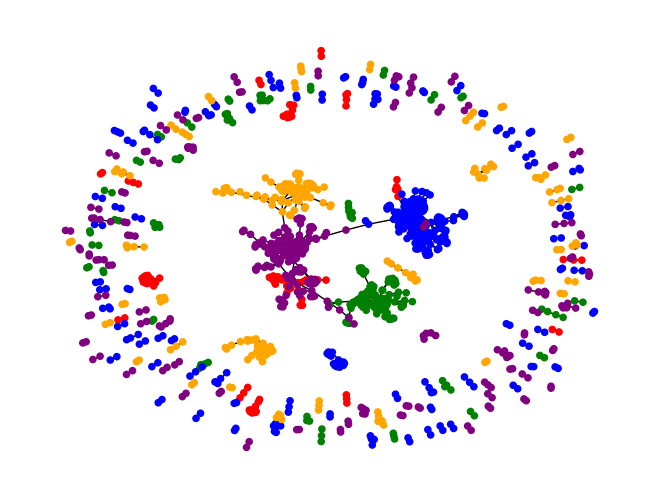

In [ ]:
def visualize_knowledge_graph(knowledge_graph, color_map=None, save_path=None):
    if color_map is None:
        color_map = "skyblue"  # Default node color if no color map is provided


   # Print the number of nodes in the graph
    num_nodes = len(knowledge_graph)
    print(f"Number of nodes in the graph: {num_nodes}")

    pos = nx.spring_layout(knowledge_graph)
    nx.draw(knowledge_graph, pos, with_labels=False, node_size=20, font_size=10, node_color=color_map, font_color="black")
    edge_labels = nx.get_edge_attributes(knowledge_graph, 'label')
    nx.draw_networkx_edge_labels(knowledge_graph, pos, edge_labels=edge_labels)

    # Check if save_path is provided, if yes, save the graph as an SVG file
    if save_path:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
        print(f"Graph visualization saved to {save_path}")
    else:
        plt.show()


# Initialize a color map to store colors for each node
color_map = {}

# Define 5 different colors
colors = ['red', 'green', 'blue', 'orange', 'purple']

# Loop through each graph and assign colors to their nodes
for i, G in enumerate(graph_collection):
    # Assign a unique color to nodes of each graph
    for node in G.nodes():
        color_map[node] = colors[i % len(colors)]

# Extract colors from the color_map dictionary and create a list of colors for all nodes
node_colors = [color_map[node] for node in mega_graph.nodes()]

file_save_path = r"/content/drive/MyDrive/IS527/final/mega_graph.svg"
#visualize_knowledge_graph(mega_graph, None, file_save_path) # Visualizes the mega graph
visualize_knowledge_graph(mega_graph, node_colors, file_save_path) # Visualizes the mega graph

In [ ]:
# Converts the KG to node embeddings
# Generate node embeddings using Node2Vec
def generate_node_embeddings(graph):
    # Create a Node2Vec object
    node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=30, workers=4)

    # Compute the node embeddings
    model = node2vec.fit(window=10, min_count=1)

    # Retrieve the node embeddings
    node_embeddings = {node: model.wv[node] for node in graph.nodes}

    return node_embeddings

# Generate node embeddings for the mega_graph
node_embeddings = generate_node_embeddings(mega_graph)

Computing transition probabilities:   0%|          | 0/1266 [00:00<?, ?it/s]

Number of embedding nodes: 1266
Node embeddings visualization saved to /content/drive/MyDrive/IS527/final/pca_mega_graph.svg


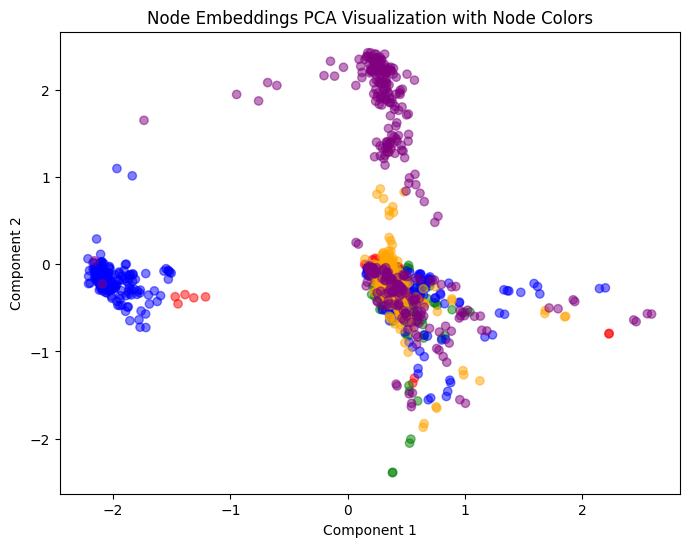

In [ ]:
def visualize_node_embeddings_pca(embeddings, num_components=2, save_path=None):

    # Print the number of embedding nodes
    num_nodes = len(embeddings)
    print(f"Number of embedding nodes: {num_nodes}")

    # Convert embeddings to numpy array
    embedding_array = np.array(list(embeddings.values()))

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=num_components)
    embedding_reduced = pca.fit_transform(embedding_array)

    # Plot the embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding_reduced[:, 0], embedding_reduced[:, 1], alpha=0.5)
    plt.title('Node Embeddings PCA Visualization')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # Check if save_path is provided, if yes, save the plot as an SVG file
    if save_path:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
        print(f'Node embeddings visualization saved to {save_path}')
    else:
        plt.show()

# With the 5 node colors
def visualize_node_embeddings_pca(embeddings, node_colors, num_components=2, save_path=None):
    # Print the number of embedding nodes
    num_nodes = len(embeddings)
    print(f"Number of embedding nodes: {num_nodes}")

    # Convert embeddings to numpy array
    embedding_array = np.array(list(embeddings.values()))

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=num_components)
    embedding_reduced = pca.fit_transform(embedding_array)

    # Plot the embeddings with node colors
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding_reduced[:, 0], embedding_reduced[:, 1], c=node_colors, alpha=0.5)
    plt.title('Node Embeddings PCA Visualization with Node Colors')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # Check if save_path is provided, if yes, save the plot as an SVG file
    if save_path:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
        print(f'Node embeddings visualization saved to {save_path}')
    else:
        plt.show()


# Specify the save path or leave it as None if you don't want to save the plot
pca_file_save_path = r"/content/drive/MyDrive/IS527/final/pca_mega_graph.svg"

# Visualize node embeddings using PCA and save the plot as an SVG file
# Pass the save_path argument explicitly
#visualize_node_embeddings_pca(node_embeddings, save_path=pca_file_save_path)
visualize_node_embeddings_pca(node_embeddings, node_colors, num_components=2, save_path=pca_file_save_path)


Number of embedding nodes: 1266


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Community detection visualization saved to /content/drive/MyDrive/IS527/final/kmeans_cluster_mega_graph.svg


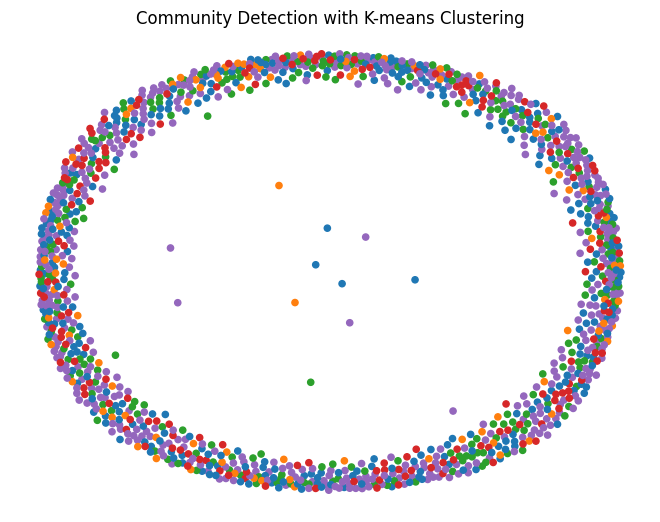

In [ ]:
# Function to perform community detection using K-means clustering on node embeddings
def community_detection(embeddings, num_clusters, save_path=None):

    # Print the number of embedding nodes
    num_nodes = len(embeddings)
    print(f"Number of embedding nodes: {num_nodes}")

    # Convert embeddings to numpy array
    embedding_array = np.array(list(embeddings.values()))

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(embedding_array)

    # Create a NetworkX graph and assign nodes to clusters
    cluster_graph = nx.Graph()
    for node, label in zip(embeddings.keys(), cluster_labels):
        cluster_graph.add_node(node, cluster=label)

    # Visualize the community detection result
    pos = nx.spring_layout(cluster_graph)  # Layout the cluster graph
    cluster_colors = [f'C{i}' for i in range(num_clusters)]  # Define colors for clusters
    node_colors = [cluster_colors[cluster_graph.nodes[node]['cluster']] for node in cluster_graph.nodes()]  # Assign colors based on clusters
    nx.draw(cluster_graph, pos, with_labels=False, node_size=20, font_size=10, node_color=node_colors, font_color="black")
    plt.title('Community Detection with K-means Clustering')

    # Check if save_path is provided, if yes, save the plot as an SVG file
    if save_path:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
        print(f"Community detection visualization saved to {save_path}")
    else:
        plt.show()


kmeans_cluster_file_save_path = r"/content/drive/MyDrive/IS527/final/kmeans_cluster_mega_graph.svg"

# Perform community detection using K-means clustering and save the visualization as an SVG file
community_detection(node_embeddings, 5, kmeans_cluster_file_save_path)


Number of embedding nodes: 1266


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Community detection visualization saved to /content/drive/MyDrive/IS527/final/community_detection_kmeans_pca_embed.svg


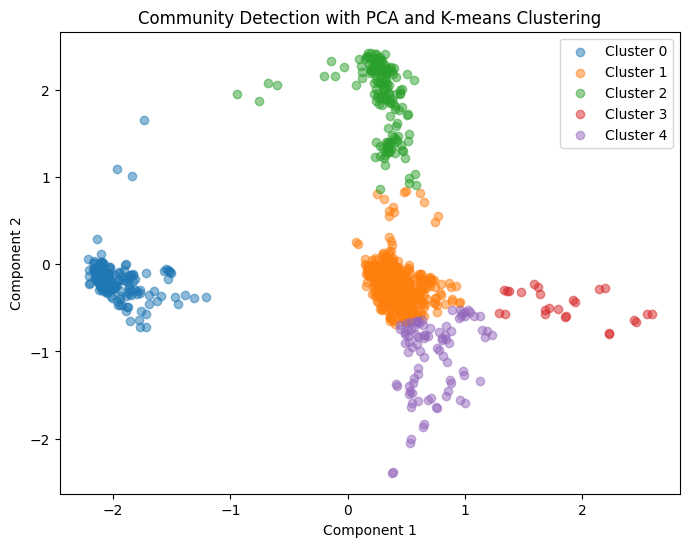

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to perform community detection on node embeddings using PCA
def community_detection_embed(embeddings, num_clusters, save_path=None):

    # Print the number of embedding nodes
    num_nodes = len(embeddings)
    print(f"Number of embedding nodes: {num_nodes}")

    # Convert embeddings to numpy array
    embedding_array = np.array(list(embeddings.values()))

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=2)
    embedding_reduced = pca.fit_transform(embedding_array)

    # Apply K-means clustering on the reduced-dimensional embeddings
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(embedding_reduced)

    # Visualize the community detection result
    plt.figure(figsize=(8, 6))
    for i in range(num_clusters):
        plt.scatter(embedding_reduced[cluster_labels == i, 0], embedding_reduced[cluster_labels == i, 1], alpha=0.5, label=f'Cluster {i}')
    plt.title('Community Detection with PCA and K-means Clustering')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()

    # Check if save_path is provided, if yes, save the plot as an SVG file
    if save_path:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
        print(f"Community detection visualization saved to {save_path}")
    else:
        plt.show()

# Assuming you have 'node_embeddings' defined somewhere in your code
# Perform community detection using PCA and K-means clustering and save the visualization as an SVG file
pca_cluster_embed_file_save_path = r"/content/drive/MyDrive/IS527/final/community_detection_kmeans_pca_embed.svg"
community_detection_embed(node_embeddings, 5, pca_cluster_embed_file_save_path)


Number of nodes in the graph: 23299
Number of communities detected: 23299
Community detection visualization saved as /content/drive/MyDrive/IS527/final/community_modularity_mega_graph.svg


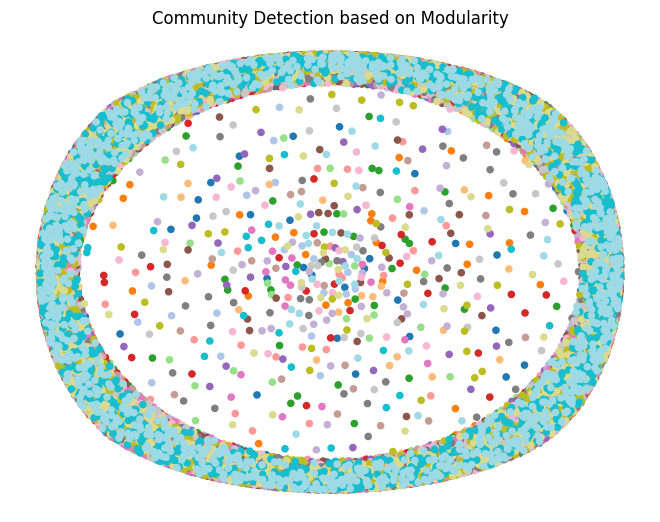

In [ ]:
from networkx.algorithms import community
from community.community_louvain import best_partition

# Function to perform community detection based on modularity
def detect_communities_modularity(graph, save_path=None):
    # Convert the graph to undirected (if it's directed)
    if graph.is_directed():
        graph = graph.to_undirected()

    # Print the number of nodes in the graph
    num_nodes = len(graph)
    print(f"Number of nodes in the graph: {num_nodes}")

    # Perform community detection using the Louvain method (based on modularity)
    partition = best_partition(graph)

    # Convert partition to a valid partition format
    partition_mapping = {node: label for label, node in enumerate(partition)}
    partition = {node: partition_mapping[node] for node in partition}

    # Return the number of communities detected
    num_communities = len(set(partition.values()))
    print(f"Number of communities detected: {num_communities}")

    # Calculate modularity score
    #modularity_score = nx.algorithms.community.quality.modularity(graph, partition)
    #print(f"Modularity Score: {modularity_score}")

    # Create a new graph with communities as node attributes
    community_graph = nx.Graph()
    for node, comm in partition.items():
        community_graph.add_node(node, community=comm)

    # Visualize the community detection result
    pos = nx.spring_layout(community_graph)  # Layout the community graph
    node_colors = [community_graph.nodes[node]['community'] for node in community_graph.nodes()]  # Assign colors based on communities
    nx.draw(community_graph, pos, with_labels=False, node_size=20, font_size=10, node_color=node_colors, cmap=plt.cm.tab20, font_color="black")
    plt.title('Community Detection based on Modularity')

    # Save the plot as an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
        print(f"Community detection visualization saved as {save_path}")

    # Show the plot interactively if save_path is not provided
    else:
        plt.show()

    return community_graph

community_modularity_file_save_path = r"/content/drive/MyDrive/IS527/final/community_modularity_mega_graph.svg"

# Assuming you have 'mega_graph' defined somewhere in your code
# Perform community detection based on modularity and save the visualization as an SVG file within the function
modularity_graph = detect_communities_modularity(mega_graph, community_modularity_file_save_path)



Number of embedding nodes: 23299
Number of communities detected: 23299
Node embedding visualization with community detection saved as /content/drive/MyDrive/IS527/final/community_modularity_embed_mega_graph.svg


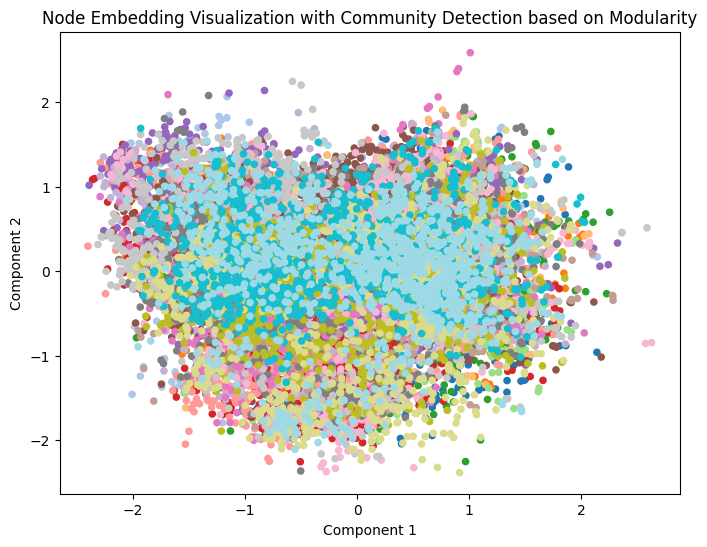

In [ ]:
from community.community_louvain import best_partition
from sklearn.decomposition import PCA
import networkx as nx
import matplotlib.pyplot as plt

def detect_communities_modularity_embed(embeddings, save_path=None):

    # Print the number of embedding nodes
    num_nodes = len(embeddings)
    print(f"Number of embedding nodes: {num_nodes}")

    # Convert embeddings to numpy array
    embedding_array = np.array(list(embeddings.values()))

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=2)
    embedding_reduced = pca.fit_transform(embedding_array)

    # Create a graph from the reduced embeddings
    G = nx.Graph()
    for node, emb in zip(embeddings.keys(), embedding_reduced):
        G.add_node(node, embedding=emb)

    # Perform community detection using the Louvain method on the reduced embeddings
    partition = best_partition(G)

    # Return the number of communities detected
    num_communities = len(set(partition.values()))
    print(f"Number of communities detected: {num_communities}")

    # Calculate modularity score
    #modularity_score = community.modularity(partition, mega_graph)
    #print(f"Modularity Score: {modularity_score}")

    # Create a new graph with communities as node attributes
    community_graph = nx.Graph()
    for node, comm in partition.items():
        community_graph.add_node(node, community=comm)

    # Visualize the node embedding visualization
    pos = {node: emb for node, emb in zip(G.nodes(), embedding_reduced)}  # Use embedding as node position
    node_colors = [partition[node] for node in G.nodes()]  # Assign colors based on communities
    # Visualize the node embedding visualization using plt.scatter
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding_reduced[:, 0], embedding_reduced[:, 1], c=node_colors, cmap=plt.cm.tab20, s=20)
    plt.title('Node Embedding Visualization with Community Detection based on Modularity')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # Save the plot as an SVG file if save_path is provided
    if save_path:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
        print(f"Node embedding visualization with community detection saved as {save_path}")
    else:
        plt.show()

    return community_graph

# Assuming you have 'node_embeddings' defined somewhere in your code
# Perform community detection based on modularity and save the visualization as an SVG file within the function
community_modularity_embed_file_save_path = r"/content/drive/MyDrive/IS527/final/community_modularity_embed_mega_graph.svg"

modularity_graph = detect_communities_modularity_embed(node_embeddings, community_modularity_embed_file_save_path)
